In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import math
from collections import Counter

# Plotting
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# Set Seed for Repeatability
np.random.seed(19680801)

# Import packages for KNN
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut
from sklearn.metrics import accuracy_score

# Import packages for Logistic Regression, SVM, and Random Forest
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import Data File into Pandas - 210 Rows and 8 Columns. The dataset has no column names
df = pd.read_csv('Data/assignment1/data_seed.dat', sep = '\s+', header = None, skiprows = 0)

# Add Column Names
df.columns = ['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv','Y']

# Scale X Columns -  The idea is to Scale each column in the dataset using built in Standard Scaler
cols_to_norm = ['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])

In [3]:

# Let's Check how the dataset looks like
df.head()

,A,P,C,L_Kern,W_Kern,Asy_Coeff,L_Kern_Grv,Y
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577,1
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013,1
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192,1
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983,1
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356,1


The Logic behind k-NN

i. You want to learn k closest neighbors of any given point and assign to that point the most common class 
(by majority vote) found in the neighborhood as defined by the closest k points. Computationally, 
k-NN is called  Lazy method because there is actually no training involved, which means, that
given a set of points with known classes (y), you can directly predict the class of a new point given that
you have y. 

ii. However, the question is how do we know what the value of "k" should be? The answer is that we do not know this 
apriori. Hence we have to do a grid search on a set of candidate values of "k" and use a resampling method such as 
5 fold CV or LOOCV (leave-one-out-of cross validation) to get a more robust answer

iii. In the context of this problem, we consider both cases i.e. (a) 5 fold CV, (b) LOOCV

(a) 5 fold CV - We create the 5 folds. We make 5 passes through the data. In each pass, we reserve 
one fold and use the other 4 folds to predict the classes of the held out fold. We then use the prediction and the 
true label to compute an accuracy for that pass. At the end of 5 passes, we average out the accuracy and
report is as the 5 fold cross validated accuracy

(b) LOOCV - Same as above. Just that instead of 5 passes we have to make "n" (Size of the dataset) passes because in
each pass we predict a [1 (true label matches predicted), 0(otherwise)] score for just one data point that is held out
using the others to predict the class of the held out datapoint. In the end we count the number of 1's and divide by n 
to get the accuracy.

In [4]:
# Define X, y
X = df[['A', 'P', 'C', 'L_Kern','W_Kern', 'Asy_Coeff','L_Kern_Grv']]
y = df['Y']
k_vals = [1, 5, 10, 15]
algorithms = ["KNN", "Logistic Regression", "SVM", "Random Forest"]
best_performances = []
best_params = []

'''        
Step - build a knn model with k = 1, 5, 10, 15, use 5-fold cv
'''
# Initialize the estimator and perform cross validation
kfv = KFold(n_splits=5, shuffle=True, random_state=19680801)
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid={'n_neighbors': k_vals}, cv=kfv, scoring='accuracy')
grid_search.fit(X, y)
cv_results = grid_search.cv_results_

# Get and print results
KF_errors = []
kf_train = []
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"k={params['n_neighbors']}: Accuracy={mean_score}")
    KF_errors.append(mean_score)
    knn.set_params(n_neighbors=params['n_neighbors'])
    knn.fit(X, y)
    y_pred = knn.predict(X)
    accuracy = accuracy_score(y, y_pred)
    kf_train.append(accuracy)
    print(f"Training Accuracy: {accuracy}")

best_performances.append(grid_search.best_score_)
best_params.append(grid_search.best_params_)
print(f"Best Parameters: {grid_search.best_params_}, Accuracy={grid_search.best_score_}")

k=1: Accuracy=0.9428571428571428
Training Accuracy: 1.0
k=5: Accuracy=0.919047619047619
Training Accuracy: 0.9476190476190476
k=10: Accuracy=0.919047619047619
Training Accuracy: 0.9333333333333333
k=15: Accuracy=0.9238095238095239
Training Accuracy: 0.9333333333333333
Best Parameters: {'n_neighbors': 1}, Accuracy=0.9428571428571428


In [5]:

'''        
Step - build a knn model with k = 1, 5, 10, 15, use LOOCV
'''
# Initialize the estimator and perform cross validation
loov = LeaveOneOut()
knn = KNeighborsClassifier()
grid_search_loo = GridSearchCV(estimator=knn, param_grid={'n_neighbors': k_vals}, cv=loov, scoring='accuracy')
grid_search_loo.fit(X, y)
cv_results = grid_search_loo.cv_results_

# Get and print results
LOO_errors = []
LOO_train = []
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"k={params['n_neighbors']}: Accuracy={mean_score}")
    LOO_errors.append(mean_score)
    knn.set_params(n_neighbors=params["n_neighbors"])
    knn.fit(X, y)
    y_pred = knn.predict(X)
    accuracy = accuracy_score(y, y_pred)
    LOO_train.append(accuracy)
    print(f"training accurcay: {accuracy}")
print(f"Best Parameters: {grid_search_loo.best_params_}, Accuracy={grid_search_loo.best_score_}")

k=1: Accuracy=0.9380952380952381
training accurcay: 1.0
k=5: Accuracy=0.9333333333333333
training accurcay: 0.9476190476190476
k=10: Accuracy=0.919047619047619
training accurcay: 0.9333333333333333
k=15: Accuracy=0.919047619047619
training accurcay: 0.9333333333333333
Best Parameters: {'n_neighbors': 1}, Accuracy=0.9380952380952381


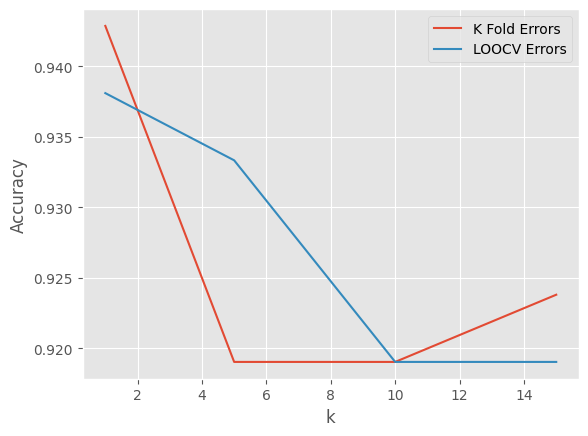

In [6]:

'''
Step
Line plot of errors for each k for 5 fold CV
Line plot of errors for each k for LOOCV

Remark:

Make sure the plot is properly labeled.

'''
plt.plot(k_vals, KF_errors, label="K Fold Errors")
plt.plot(k_vals, LOO_errors, label="LOOCV Errors")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:

'''
Problem 6.2 -- 

Apply logistic regression, SVM, and random forest. The sequence of steps will be roughly the same to the knn.

'''
kfv = KFold(n_splits=5, shuffle=True, random_state=19680801)

# Logistic Regression
c_vals = [0.01, 0.1, 0.3, 0.5, 0.75, 1]
logreg = LogisticRegression(random_state=19680801, max_iter=1000)
grid_search_log = GridSearchCV(estimator=logreg, param_grid={"C": c_vals}, cv=kfv, scoring="accuracy")
grid_search_log.fit(X, y)

cv_results_kfv = grid_search_log.cv_results_

# Compare Performance and print results
log_errors = []
print("Logistic Regression: C = Lambda")
for mean_score, params in zip(cv_results_kfv["mean_test_score"], cv_results_kfv["params"]):
    log_errors.append(mean_score)
    print(f"{params}: Accuracy={mean_score}")
    logreg.set_params(C=params["C"])
    logreg.fit(X, y)
    y_pred = logreg.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"training accuracy: {accuracy}")

best_performances.append(grid_search_log.best_score_)
print(f"Best Parameters: {grid_search_log.best_params_}, Accuracy={grid_search_log.best_score_}")

Logistic Regression: C = Lambda
{'C': 0.01}: Accuracy=0.9238095238095239
training accuracy: 0.919047619047619
{'C': 0.1}: Accuracy=0.9285714285714286
training accuracy: 0.9333333333333333
{'C': 0.3}: Accuracy=0.9238095238095239
training accuracy: 0.9285714285714286
{'C': 0.5}: Accuracy=0.9285714285714286
training accuracy: 0.9380952380952381
{'C': 0.75}: Accuracy=0.9333333333333333
training accuracy: 0.9428571428571428
{'C': 1}: Accuracy=0.9333333333333333
training accuracy: 0.9428571428571428
Best Parameters: {'C': 0.75}, Accuracy=0.9333333333333333


In [8]:
# SVM
kernels = ["linear", "poly", "sigmoid", "rbf"]
sup_v = svm.SVC(random_state=19680801)
grid_search_svm = GridSearchCV(estimator=sup_v, param_grid={"kernel": kernels, "C": c_vals}, cv=kfv, scoring="accuracy")
grid_search_svm.fit(X, y)

cv_results_svm = grid_search_svm.cv_results_

# Print results
SVM_errors = []
print("SVM - Kernel")
for mean_score, params in zip(cv_results_svm["mean_test_score"], cv_results_svm["params"]):
    SVM_errors.append(mean_score)
    print(f"{params}: Accuracy={mean_score}")
    sup_v.set_params(C=params["C"], kernel=params["kernel"])
    sup_v.fit(X, y)
    y_pred = sup_v.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"training accuracy: {accuracy}")

best_performances.append(grid_search_svm.best_score_)
print(f"Best Parameters: {grid_search_svm.best_params_}, Accuracy={grid_search_svm.best_score_}")

SVM - Kernel
{'C': 0.01, 'kernel': 'linear'}: Accuracy=0.9142857142857143
training accuracy: 0.9333333333333333
{'C': 0.01, 'kernel': 'poly'}: Accuracy=0.5761904761904761
training accuracy: 0.6333333333333333
{'C': 0.01, 'kernel': 'sigmoid'}: Accuracy=0.6047619047619047
training accuracy: 0.8761904761904762
{'C': 0.01, 'kernel': 'rbf'}: Accuracy=0.4095238095238095
training accuracy: 0.9333333333333333
{'C': 0.1, 'kernel': 'linear'}: Accuracy=0.9238095238095239
training accuracy: 0.9380952380952381
{'C': 0.1, 'kernel': 'poly'}: Accuracy=0.7571428571428571
training accuracy: 0.7619047619047619
{'C': 0.1, 'kernel': 'sigmoid'}: Accuracy=0.9095238095238095
training accuracy: 0.9142857142857143
{'C': 0.1, 'kernel': 'rbf'}: Accuracy=0.919047619047619
training accuracy: 0.9285714285714286
{'C': 0.3, 'kernel': 'linear'}: Accuracy=0.9333333333333333
training accuracy: 0.9523809523809523
{'C': 0.3, 'kernel': 'poly'}: Accuracy=0.8
training accuracy: 0.819047619047619
{'C': 0.3, 'kernel': 'sigmoid'

In [9]:
# Random Forest
n_estimator = [10, 50, 100, 200, 500]
depths = [2, 4, 6, 8, 10]
rf = RandomForestClassifier(random_state=19680801)
grid_search_rf = GridSearchCV(estimator=rf, param_grid={"n_estimators": n_estimator, "max_depth": depths}, cv=kfv, scoring="accuracy")
grid_search_rf.fit(X, y)

cv_results_rf = grid_search_rf.cv_results_

# Print the Results
RF_errors = []
print("Random Forest")
for mean_score, params in zip(cv_results_rf["mean_test_score"], cv_results_rf["params"]):
    RF_errors.append(mean_score)
    print(f"{params}: Accuracy={mean_score}")
    rf.set_params(n_estimators=params["n_estimators"], max_depth=params["max_depth"])
    rf.fit(X, y)
    y_pred = rf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"training accuracy: {accuracy}")

best_performances.append(grid_search_rf.best_score_)
print(f"Best Parameters: {grid_search_rf.best_params_}, Accuracy={grid_search_rf.best_score_}")

Random Forest
{'max_depth': 2, 'n_estimators': 10}: Accuracy=0.8619047619047618
training accuracy: 0.8952380952380953
{'max_depth': 2, 'n_estimators': 50}: Accuracy=0.8809523809523808
training accuracy: 0.9285714285714286
{'max_depth': 2, 'n_estimators': 100}: Accuracy=0.8761904761904761
training accuracy: 0.9333333333333333
{'max_depth': 2, 'n_estimators': 200}: Accuracy=0.8761904761904761
training accuracy: 0.9285714285714286
{'max_depth': 2, 'n_estimators': 500}: Accuracy=0.8809523809523808
training accuracy: 0.919047619047619
{'max_depth': 4, 'n_estimators': 10}: Accuracy=0.895238095238095
training accuracy: 0.9714285714285714
{'max_depth': 4, 'n_estimators': 50}: Accuracy=0.9095238095238095
training accuracy: 0.9809523809523809
{'max_depth': 4, 'n_estimators': 100}: Accuracy=0.9047619047619049
training accuracy: 0.9761904761904762
{'max_depth': 4, 'n_estimators': 200}: Accuracy=0.9142857142857144
training accuracy: 0.9761904761904762
{'max_depth': 4, 'n_estimators': 500}: Accuracy

Text(0, 0.5, 'Accuracy')

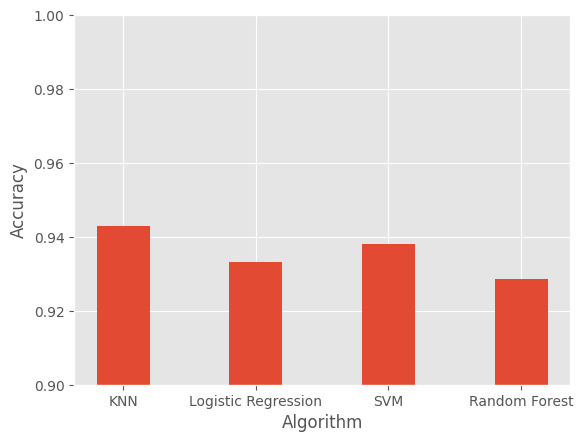

In [10]:
# Plot
plt.bar(algorithms, best_performances, width=0.4)
plt.ylim(0.9, 1)
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
